Style transfer consists in generating an image with the same "content" as a base image, but with the "style" of a different picture (in this case impressionist painting). This is achieved through the optimization of a loss function that has 3 components: "style loss", "content loss", and "total variation loss".

# Importing libraries

Importing all the essential libraries required for this project. I
Importing the TensorFlow and Keras deep learning frameworks for building the neural style transfer model.
Importing the VGG-19 transfer learning model for the feature extraction procedure.

In [7]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import os, gc , warnings
import tensorflow.keras.preprocessing.image as process_im
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import IPython.display
%matplotlib inline

# Import dataset

Datasets are made by me.In impressionist dataset I used 5 paintings of 5 difrent artists. In second dataset I used my dog's photos. 

In [8]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/doghera/IMG_20191226_121702.jpg
/kaggle/input/doghera/IMG_20190703_142644.jpg
/kaggle/input/doghera/20181115_213204.jpg
/kaggle/input/doghera/20180101_042103.jpg
/kaggle/input/doghera/20171126_162331.jpg
/kaggle/input/doghera/dog.jpg
/kaggle/input/doghera/IMG_20190703_142916.jpg
/kaggle/input/doghera/20180318_200215.jpg
/kaggle/input/doghera/20171210_194115.jpg
/kaggle/input/doghera/IMG_20190703_142734.jpg
/kaggle/input/doghera/20171111_115808.jpg
/kaggle/input/impressionism/berthe-morisot-psyche-mirror.jpg
/kaggle/input/impressionism/Mary_Cassatt_Automne_portrait_de_Lydia_Cassatt_1880_ppp706_Petit_Palais.jpg
/kaggle/input/impressionism/Lilla Cabot Perry - Giverny Landscape in Monets Garden.jpg
/kaggle/input/impressionism/berthe-morisot-jardin-a-bougival.jpg
/kaggle/input/impressionism/Vincent_van_Gogh_Seascape_at_Saintes-Maries_Saintes-Maries-de-la-Mer_1888.jpg
/kaggle/input/impressionism/Claude-Monet-Impression-Sunrise-1872.jpg
/kaggle/input/impressionism/Lilla Cabot Pe

Uplowding two images (content and style) as input. Later on they are synthesized to a third image that has the semantic content of the first image and the style of the second. 

In [9]:
content_path = ('../input/doghera/IMG_20190703_142644.jpg')
style_path = ('../input/impressionism/Lilla_Cabot_Perry_-_Cliffs_at_Etretat.jpg')

# Image Manipulations:

Define a function to load an image and limit its maximum dimension to 512 pixels.

This part refers to the number of pixels in width and height direction. Interestingly, content and style images can have different resolutions. Generated image has the same resolution as the content image.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


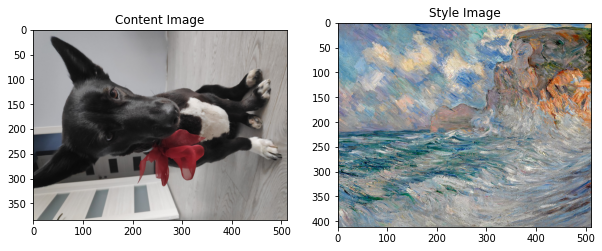

In [10]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0)                                       
    return im_array

def imshow(img,title=None):
    img=np.squeeze(img,axis=0) 
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))
    
content = load_file(content_path)
style = load_file(style_path)

plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
imshow(content,'Content Image')
plt.subplot(1,2,2)
imshow(style,'Style Image')
plt.show()

def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

Util function to convert a tensor into a valid image.

In [11]:
# Util function to convert a tensor into a valid image
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 

  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
    
  # 'BGR'->'RGB'
  x = x[:, :, ::-1] 
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [12]:
im=img_preprocess(content_path)
im_2 = deprocess_img(im)
# Content layer
content_layers = ['block1_conv2',
                  'block2_conv2',
                  'block3_conv2']
# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

def get_model(): 
     #Load our model. We load pretrained VGG, trained on imagenet data
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    # Get output layers corresponding to style and content layers 
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    # Build model 
    return models.Model(vgg.input,model_output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


In [13]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

2022-10-31 13:00:21.439905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 13:00:21.440820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 13:00:21.731324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 13:00:21.733608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 13:00:21.734975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [14]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,944,960
Trainable params: 0
Non-trainable params: 12,944,960
_________________________________________________________________


# Loss functions

The content loss is a function that represents a weighted version of the content distance for an individual layer.

In [15]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

In order to calculate the style loss, we need to compute the gram matrix. 

In [16]:
def gram_matrix(tensor): 
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

The style loss module is implemented similarly to the content loss module.

In [17]:
def get_style_loss(noise,target):
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    gram_noise=gram_matrix(noise)
   
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [18]:
def get_features(model,content_path,style_path):
     # Load our images in 
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    # batch compute content and style features
    content_output=model(content_img)
    style_output=model(style_image)
     # Get the style and content feature representations from our model  
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

Total loss function is a combination of the content loss and the style loss. 

In [19]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights     
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    # Accumulate content losses from all layers
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
     
    # Get total loss
    total_loss = content_loss + style_loss
    return total_loss,style_loss,content_loss

# Training loop

In [20]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

# VGG19 model loaded with pre-trained ImageNet weights
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

# Weights of the different loss components
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e1):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
   

     # Get the style and content feature representations (from our specified intermediate layers)
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    # Set initial image
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
     # Create our optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    # Store our best result
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    norm_means = np.array([105, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    image_no = 1
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)   
        if total_loss<best_loss:
             # Update best loss and best image from total loss.
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())   
        if i%25==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            m = Image.fromarray(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))

            
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    IPython.display.clear_output(wait=True)
    return best_img,best_loss,imgs

# Generated image display

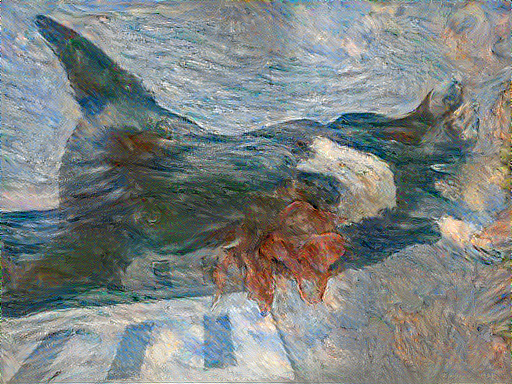

Epoch: 3975
Total loss: 3.8057e+07, style loss: 7.0246e+06, content loss: 3.1033e+07, 


In [21]:
best, best_loss,image = run_style_transfer(content_path,style_path, epochs=4000)

Showing 3 images: content, style and generated.

In [22]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_file(content_path) 
    style = load_file(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

  
    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


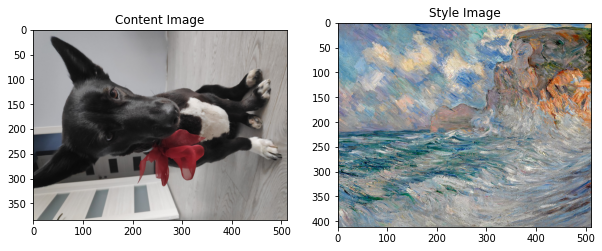

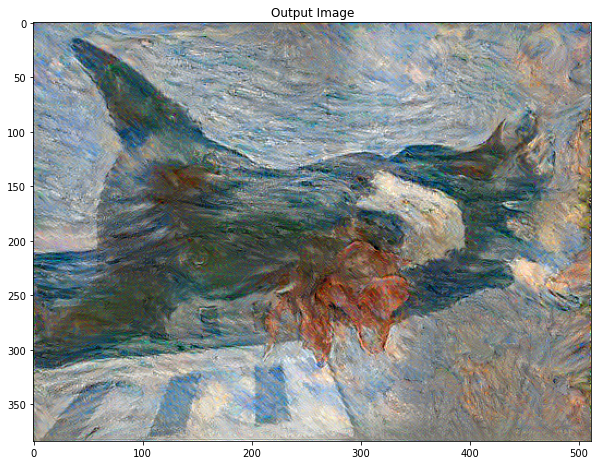

In [23]:
show_results(best, content_path, style_path)

Rotating generated image and saving it.

Rotation step is not always necessary. Only when generated image is needed in a different angle. Usually it should be done inside the dataset, but in this case the final image looks better when content image is horizontal and rotated after it is generated. This way it matches the brushstrokes of the style image.

In [24]:
Final = Image.fromarray(np.rot90(best, 3)).save("./Final.jpg") # Rotating image 3 time in 90 degrees. Then saving it as jpg file under the name "Final".
# Final = Image.fromarray(best).save("./Final.jpg") # Sving the genareted image. 

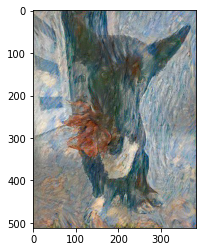

In [25]:
im = Image.open('./Final.jpg')
plt.imshow(im)
plt.show()

In [26]:
image = Image.open(r"./Final.jpg")
print(f"Original size : {image.size}")

Original size : (384, 512)


At this point the entire architecture is constructed from scratch and the obtained model is used to evaluate and generate the modified images. This deep learning network works with the help of two primary constituents. The content picture and the style picture. Combining these two images together produces a generated image. Using this neural network can be generated artworks that anyone can make. Of course it still needs that user would choose esthetically compatible images.

This time the generated image seems to lake quality, so it was decided to enhance it. For that it will be used ESRGAN. It's a TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network for image enhancing. Model was trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

In [27]:
# Declaring Constants.
IMAGE_PATH = "Final.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

# Defining Helper Functions

In [28]:
# Loads image from path and preprocesses to make it model ready.
def preprocess_image(image_path):

  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

# Saves unscaled Tensor Images.
def save_image(image, filename):

  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

%matplotlib inline
def plot_image(image, title=""):

  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [29]:
%matplotlib inline
def plot_image(image, title=""):
# Plots images from image tensors.
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

# Performing Super Resolution of images loaded from path

In [30]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


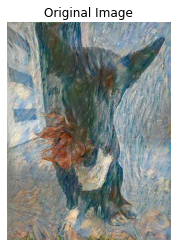

In [31]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [32]:
# Loading model. 
model = hub.load(SAVED_MODEL_PATH)

In [33]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

2022-10-31 13:10:07.424511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Time Taken: 3.728048


Saved as Super Resolution.jpg


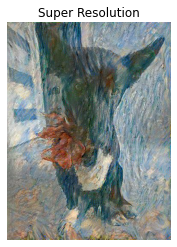

In [34]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

# Comparing Outputs side by side.

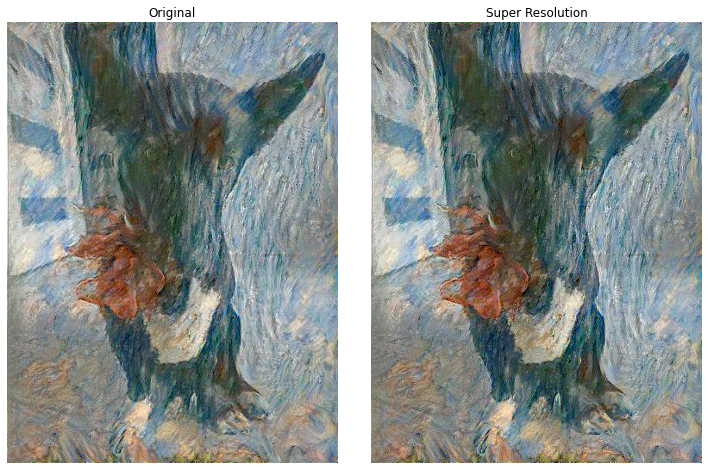

In [35]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 2)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")


Neural style transfer is very interesting project. It can be very creative, but sometimes challenging. The most enjoyable aspect of Neural Style Transfer is that, rather than uniformity of results, various visual results are obtained with hyperparameter tuning. Despite of hyperparameter tuning generated image can be unsatisfying. For that not to happen the content and the style must have some common ground (for example: similar colors, similar things composition.) For better result the content should be rotated according to the content brush strokes. 

Examples of bad matching: nr1, nr2, nr3, nr4.

Examples of good matching: nr5, nr6, nr7, nr8, nr9, nr10, nr11, nr12, nr13, nr14, nr15, nr16, nr17, nr18.

After neural style transfer the genarates result may seem blure, enhancing image resolution can help with that. In this project was used TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network. More information can be obtained: https://analyticsindiamag.com/guide-to-image-super-resolution-by-esrgan/.
 

At this point the result is almost satisfying, though could be improved (proper size for printing on canvas, image automatic rotation (for this must be obtained more pictures of the same dog, the datasets that already exists with dog images my not work efficiently, because they are collected from pure breeds)). 


Text(0.5, 1.0, 'nr4')

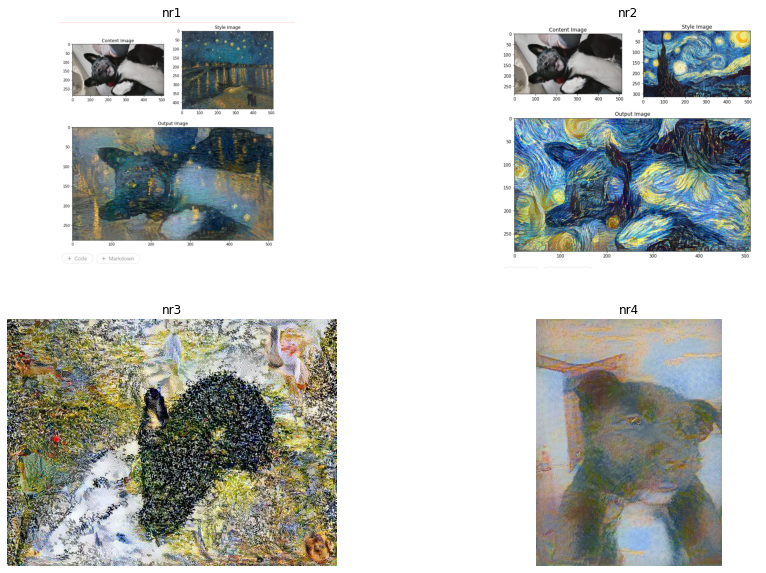

In [40]:
import matplotlib.image as img
fig = plt.figure(figsize=(15, 10)) # create figure

# setting values to rows and column variables
rows = 2
columns = 2

# reading images
nr1 = img.imread("../input/output/bad.PNG") 
nr2 = img.imread("../input/output/2bad.PNG")
nr3 = img.imread("../input/output/Super Resolution (2).jpg")
nr4 = img.imread("../input/output/Super Resolution (1).jpg")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(nr1)
plt.axis('off')
plt.title("nr1")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(nr2)
plt.axis('off')
plt.title("nr2")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(nr3)
plt.axis('off')
plt.title("nr3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(nr4)
plt.axis('off')
plt.title("nr4")

Text(0.5, 1.0, 'nr16')

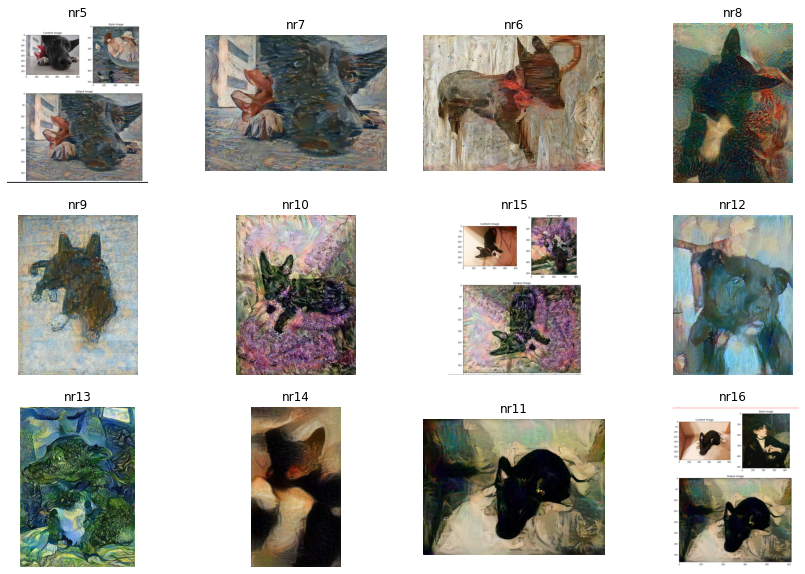

In [45]:
fig = plt.figure(figsize=(15, 10)) # create figure

# setting values to rows and column variables
rows = 3
columns = 4

# reading images
nr5 = img.imread("../input/output/Verygood.PNG") 
nr6 = img.imread("../input/output/Super Resolution (8).jpg")
nr7 = img.imread("../input/output/Super Resolution (7).jpg")
nr8 = img.imread("../input/output/Super Resolution (6).jpg")
nr9 = img.imread("../input/output/Super Resolution (5).jpg") 
nr10 = img.imread("../input/output/Super Resolution (4).jpg")
nr11 = img.imread("../input/output/Super Resolution (3).jpg")
nr12 = img.imread("../input/output/Super Resolution (15).jpg")
nr13 = img.imread("../input/output/Super Resolution (13).jpg")
nr14 = img.imread("../input/output/Super Resolution (11).jpg")
nr15 = img.imread("../input/output/Capture1.PNG")
nr16 = img.imread("../input/output/Capture.PNG")

# Adds a subplot position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(nr5)
plt.axis('off')
plt.title("nr5")


fig.add_subplot(rows, columns, 3)

plt.imshow(nr6)
plt.axis('off')
plt.title("nr6")


fig.add_subplot(rows, columns, 2)

plt.imshow(nr7)
plt.axis('off')
plt.title("nr7")


fig.add_subplot(rows, columns, 4)

plt.imshow(nr8)
plt.axis('off')
plt.title("nr8")


fig.add_subplot(rows, columns, 5)

plt.imshow(nr9)
plt.axis('off')
plt.title("nr9")
  

fig.add_subplot(rows, columns, 6)
  

plt.imshow(nr10)
plt.axis('off')
plt.title("nr10")
  

fig.add_subplot(rows, columns, 11)
  

plt.imshow(nr11)
plt.axis('off')
plt.title("nr11")


fig.add_subplot(rows, columns, 8)

plt.imshow(nr12)
plt.axis('off')
plt.title("nr12")


fig.add_subplot(rows, columns, 9)

plt.imshow(nr13)
plt.axis('off')
plt.title("nr13")
  

fig.add_subplot(rows, columns, 10)
  

plt.imshow(nr14)
plt.axis('off')
plt.title("nr14")
  

fig.add_subplot(rows, columns, 7)
  

plt.imshow(nr15)
plt.axis('off')
plt.title("nr15")


fig.add_subplot(rows, columns, 12)

plt.imshow(nr16)
plt.axis('off')
plt.title("nr16")
